## CIFAR10_GAN

In [4]:
import pandas as pd
import numpy as np 
import os 
import time
from pathlib import Path

import PIL
import imageio
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow.keras import layers


In [12]:
# file_path = '/content/drive/MyDrive/Colab_Notebook/aiffel_lms/E13_GAN'
file_path = '/Users/js8456/google_drive/Colab_Notebook/aiffel_lms/E13_GAN'

# new_list = ['/cifar10_3/generated_samples', '/cifar10_3/training_checkpoints', 
#             '/cifar10_3/training_history']

# for path in new_list:
#   os.makedirs(file_path + path)

data_path = file_path + '/cifar10_3'
generated_samples_path = data_path + '/generated_samples'
training_ckpt_path = data_path + '/training_checkpoints'
training_history_path = data_path +'/training_history'

## 1. Dataset 

In [3]:
cifar10 = tf.keras.datasets.cifar10

#label 필요 없으니 x 데이터만
(train_x, _), (test_x, _) = cifar10.load_data()

170508288/170498071 [==============================] - 2s 0us/step


In [4]:
print(train_x.max(), test_x.min())
print(train_x.shape, test_x.shape)

255 0
(50000, 32, 32, 3) (10000, 32, 32, 3)


- 이미지가 32, 32픽셀의 3차원이고, 각 픽셀은 0-255의 값을 갖는 것을 확인
- min -1, max 1로 정규화 시키기 

In [5]:
# -1 to 1 로 픽셀 정규화
train_x = (train_x - 127.5) / 127.5
print(train_x.max(), train_x.min())
print(train_x.shape)

1.0 -1.0
(50000, 32, 32, 3)


In [6]:
train_x = train_x.astype('float32')
train_x.shape

(50000, 32, 32, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

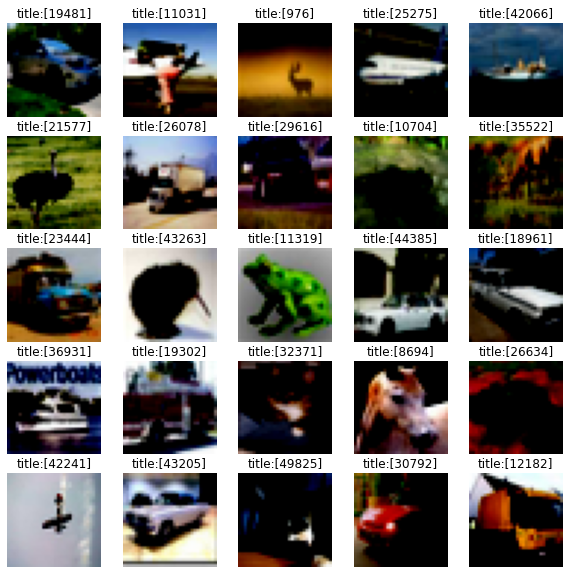

In [7]:
# train_x 데이터 확인하기 

plt.figure(figsize=(10, 10))
for i in range(25):
  x = np.random.randint(0, 50000, size=1)
  plt.subplot(5,5, i+1)
  plt.imshow(train_x[x].reshape(32, 32, 3))
  plt.title(f'title:{x}')
  plt.axis('off')
plt.show()

## 2. tf.Dataset | Minibatch 생성 

In [8]:
BUFFER_SIZE = 50000 # 전체 data shuffle할 예정 
BATCH_SIZE = 64

In [9]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

## 3. Generator Model 생성

In [10]:
from tensorflow.keras import layers

In [11]:
def make_generator_model():
  model = tf.keras.Sequential([
          layers.Dense(8*8*256, use_bias = False, input_shape = (100,)),
          layers.BatchNormalization(),
          layers.ELU(),

          layers.Reshape((8, 8, 256)),

          layers.Conv2DTranspose(128, kernel_size = (5,5), strides = (1,1), padding = 'same', use_bias = True),
          layers.BatchNormalization(),
          layers.ELU(),

          layers.Conv2DTranspose(64, kernel_size = (5,5), strides = (2,2), padding = 'same', use_bias = True),
          layers.BatchNormalization(),
          layers.ELU(),

          layers.Conv2DTranspose(3, (5,5), strides = (2,2), padding = 'same', use_bias = False, activation = 'tanh')

  ])

  return model

In [12]:
# model 이용하여 (32, 32, 3) 샘플 이미지 생성해보기 
generator = make_generator_model()
generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16384)             1638400   
_________________________________________________________________
batch_normalization (BatchNo (None, 16384)             65536     
_________________________________________________________________
elu (ELU)                    (None, 16384)             0         
_________________________________________________________________
reshape (Reshape)            (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 8, 8, 128)         819328    
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 8, 128)         512       
_________________________________________________________________
elu_1 (ELU)                  (None, 8, 8, 128)         0

- shape = (1, 100) 모양의 랜덤 노이즈 백터 생성하여 이미지 생성 test

In [13]:
noise = tf.random.normal([1, 100])

In [14]:
generated_image = generator(noise, training = False)

In [15]:
generated_image.shape

TensorShape([1, 32, 32, 3])

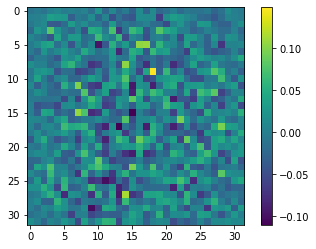

In [16]:
# plot

plt.imshow(generated_image[0, :, :, 0])
plt.colorbar()
plt.show()

training을 진행하지 않고 noise로 생성한 이미지이기 때문에 어떠한 형태를 가진 이미지라고 생각할 수 없음  
- 0~ 1사이의 규격에 맞는 32 * 32 이미지가 생성된 것을 확인 

## 4. Discriminator Model 생성 

In [17]:
def make_discriminator_model():
  model = tf.keras.Sequential([
          layers.Conv2D(64, (5, 5), (2,2), padding = 'same', input_shape = [32, 32, 3]),
          layers.ELU(),
          # layers.Dropout(0.2),

          layers.Conv2D(128, (5, 5), (2,2), padding = 'same'),
          layers.ELU(),
          layers.Dropout(0.2),

          layers.Flatten(),

          layers.Dense(1)

  ])

  return model

# 마지막 output은 1dim으로 나오게끔 설정함 

In [18]:
discriminator = make_discriminator_model()
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 16, 16, 64)        4864      
_________________________________________________________________
elu_3 (ELU)                  (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 128)         204928    
_________________________________________________________________
elu_4 (ELU)                  (None, 8, 8, 128)         0         
_________________________________________________________________
dropout (Dropout)            (None, 8, 8, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                

위에서 생성했던 test image의 discriminate 값 확인하기 

In [19]:
test_result = discriminator(generated_image, training = False)
test_result

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.01003661]], dtype=float32)>

해당 이미지가 real 이미지라고 생각하는 정도의 값이 0.01003661으로 나옴을 확인함 : 낮기 때문에 의미 없음 
- 다른 실험 결과에서는 0.5값이 나온 경우도 있는데 이미지의 차이가 어느정도 느껴지긴 함 


## 5. Loss Function & Optimizer Function

Loss Function  
- 2개의 이미지(real, fake)를 비교하는 것이기 때문에 BinaryCrossEntropy사용 
- 실제 이미지 1, fake 이미지 0과의 loss 값을 확인하는 것이기 때문에 Generator는 Discriminator가 fake image를 1과 가까운 것으로 확인하도록 하는 것이 목표, Discriminator는 real_image가 1에 가깝고 fake image가 0에 가까운 것이 목표

In [20]:
# Discriminator 결과값이 0-1로 수렴하지 않기 때문에, 내부에서 sigmoid를 사용하여 정규화하기 위해
# from_logits= True 사용 
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

### 5-1. Generator Loss Function

In [21]:
def generator_loss(fake_output):
  return cross_entropy(tf.ones_like(fake_output), fake_output)

# fake_output과 같은 사이즈의 1로만 구성된 tf를 만들어서 fake_output과 crossentropy 비교 
# real 값인 1과 비교가 되는 것이기 때문에 낮은 loss를 가질수록 generator는 great

### 5-2. Discriminator Loss Function

In [22]:
def discriminator_loss(real_output, fake_output):
  real_loss = cross_entropy(tf.ones_like(real_output), real_output) # 낮은 loss일수록 좋음 
  fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output) # 얘도 낮은 loss일수록 좋음 
  total_loss = real_loss + fake_loss 
  return total_loss


Generator Loss Function, Discriminator Loss Function 2개 모두 낮은 값의 loss를 갖는 것이 좋도록 세팅함 

### 5-3. Discriminator Accuracy
- real accuracy과 fake acc 두개 모두 초반에는 1과 가깝다가 점차 0.5에 가까워지는 것이 이상적임 
- fake accuracy는 0과 가까운 것이 Discriminator를 잘 속이고 있다는 것 

In [23]:
def discriminator_accuracy(real_output, fake_output):
  real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
  fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
  return real_accuracy, fake_accuracy

### 5-4. Optimizer
- lr은 0.0002로 세팅
- bete_1 = 0.7로 수정 (default가 0.9)
- Generator, Discriminator은 각자 학습하기 때문에 각자 optimizer가 필요함 

In [24]:
# beta값 변경 
generator_optimizer = tf.keras.optimizers.Adam(0.0002, beta_1 = 0.7)
discriminator_optimizer = tf.keras.optimizers.Adam(0.0002,beta_1 = 0.7)

## 6. Functions for Training 

### 6-1. Minibatch Trining Fuction
- `@tf.function` 데코레이터를 사용하여 미니배치가 학습될 때 한개씩 open되고 close되는 형식을 만듦 
- Tensorflow의 graph 노드를 손쉽게 사용할 수 있음 

In [25]:
# 입력 노이즈의 차원을 100, 샘플 생성이 16개 되도록 seed로 고정 

noise_dim = 100 
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

TensorShape([16, 100])

In [26]:
@tf.function
def train_step(images): 
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  # input을 위한 랜덤 노이즈 생성

    # gradienttape 생성 : 가중치 갱신을 위한 Gradient를 자동 미분으로 계산
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  
        generated_images = generator(noise, training=True)  

        real_output = discriminator(images, training=True)# 추후 train_dataset이 images로 들어갈 예정 
        fake_output = discriminator(generated_images, training=True)# noise생성 이미지 

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output) 
    
    # backpropagation으로 gradient 계산 
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    # 모델 학습 과정 -> optimizer 적용 
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy 

[TIP]. 

`tf.GradientTape()`
- 자동미분을 위한 API
- 컨텍스트 안에서 실행된 모든 연산을 tape에 기록 
- reverse mode differentiation을 사용해 기록된 연산의 gredient를 계산 

### 6-2. Train Step 생성 Sample 이미지 저장

In [27]:
# train step과 함께 일정 간격으로 학습 결과를 볼 수 있는 샘플을 생성하는 func

def generate_and_save_images(model, epoch, it, sample_seeds):
  predictions = model(sample_seeds, training = False)

  fig = plt.figure(figsize = (4,4))
  for i in range(predictions.shape[0]):
    plt.subplot(4, 4, i+1)
    plt.imshow(predictions[i, :, :, 0])# 이걸 0으로 세팅해둬서 이미지 색이 다름 
    plt.axis('off')

    plt.savefig('/content/drive/MyDrive/Colab_Notebook/aiffel_lms/E13_GAN/cifar10_3/generated_samples/sample_epoch_{:04d}_iter_{:03d}.png'.format(epoch, it))
    plt.show()

In [29]:
# loss 및 accuracy plot 함수 

from matplotlib.pylab import rcParams # 베이스로 세팅해놓는 것을 서포트하는 함수 
rcParams['figure.figsize'] = 15, 6 

def draw_train_history(history, epoch):
  #summarize history for loss
  plt.subplot(211)
  plt.plot(history['gen_loss'])
  plt.plot(history['disc_loss'])
  plt.title('model loss')
  plt.xlabel('batch iters')
  plt.ylabel('loss')
  plt.legend(['gen_loss', 'disc_loss'], loc = 'upper left')

  #summarize history for accuracy
  plt.subplot(212)
  plt.plot(history['fake_accuracy'])
  plt.plot(history['real_accuracy'])
  plt.title('discriminator accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('batch iters')
  plt.legend(['fake_accuracy', 'real_accuracy'], loc = 'upper left')

  #training_history 디렉토리에 epoch 별로 그래프를 이미지 파일로 저장 
  plt.savefig('/content/drive/MyDrive/Colab_Notebook/aiffel_lms/E13_GAN/cifar10_3/training_history/sample_epoch_{:04d}.png'.format(epoch))
  plt.show()


In [30]:
# Training 중 checkpoint 생성하여 추후 사용 예방 

checkpoint_prefix = os.path.join(training_ckpt_path, 'ckpt')
checkpoint = tf.train.Checkpoint(generator_optimizer = generator_optimizer, 
                                 discriminator_optimizer = discriminator_optimizer,
                                 generator = generator,
                                 discriminator = discriminator)


In [31]:
# history plot을 위한 func

def train(dataset, epochs, save_every):
  start = time.time()
  history = {'gen_loss': [], 'disc_loss':[], 'real_accuracy': [], 'fake_accuracy': []}

  for epoch in range(epochs):
    epoch_start = time.time()
    for it, image_batch in enumerate(dataset):
      gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
      history['gen_loss'].append(gen_loss)
      history['disc_loss'].append(disc_loss)
      history['real_accuracy'].append(real_accuracy)
      history['fake_accuracy'].append(fake_accuracy)

      if it % 50 == 0:
        display.clear_output(wait = True)
        generate_and_save_images(generator, epoch+1, it+1, seed)
        print('Epoch {} | iter {}'.format(epoch+1, it+1))
        print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-start)))
      
    if (epoch +1) % save_every == 0:
      checkpoint.save(file_prefix=checkpoint_prefix)

    display.clear_output(wait = True)
    generate_and_save_images(generator, epochs, it, seed)
    print('Time for training : {}sec'.format(int(time.time()-start)))

    draw_train_history(history, epoch)



In [ ]:
# 저장될 간격 및 epoch 지정 

save_every = 5
EPOCHS = 100

## Training & 결과 확인 

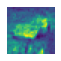

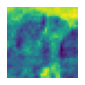

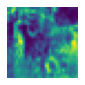

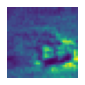

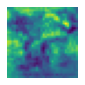

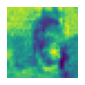

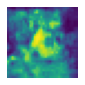

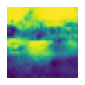

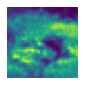

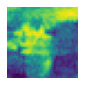

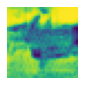

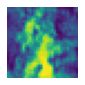

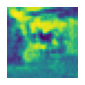

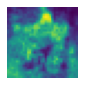

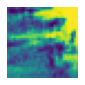

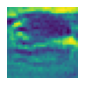

Time for training : 6898sec


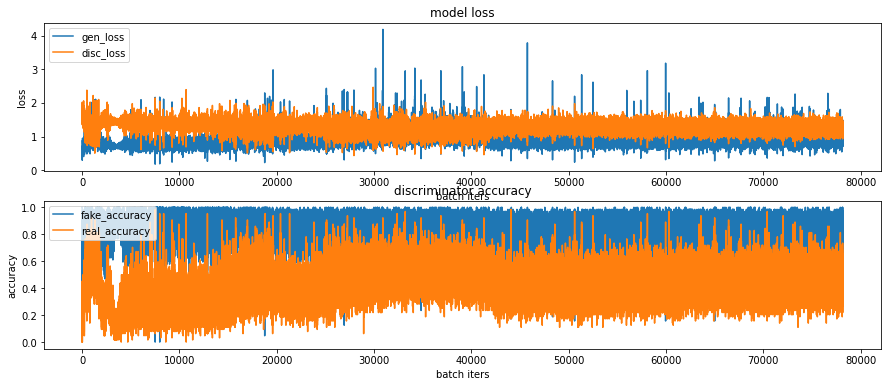

CPU times: user 1h 19min 38s, sys: 2min 54s, total: 1h 22min 32s
Wall time: 1h 55min 2s


In [33]:
%%time
train(train_dataset, EPOCHS, save_every)

## Train Process History GIF

In [15]:
os.mkdir(file_path + '/cifar10_3/gif')
anim_path = file_path + '/cifar10_3/gif'

In [16]:
import glob

anim_file = anim_path + '/e13_1_dcgan.gif'

with imageio.get_writer(anim_file, mode = 'I') as writer:
  filenames = glob.glob('/content/drive/MyDrive/Colab_Notebook/\
                        aiffel_lms/E13_GAN/cifar10_3/generated_samples/sample*.png')
  filenemes = sorted(filenames)
  last = -1
  for i, filename in enumerate(filenames):
    frame = 2*(i**0.5)
    if round(frame) > round(last):
      last = frame
    else:
      continue
    image = imageio.imread(filename)
    writer.append_data(image)
  # image = imageio.imread(filename)
  # writer.append_data(image)


In [22]:
# !ls -l ~/content/drive/MyDrive/Colab_Notebook/aiffel_lms/E13_GAN/cifar10_3/gif/e13_1_dcgan.gif
!ls -l /Users/js8456/google_drive/Colab_Notebook/aiffel_lms/E13_GAN/cifar10_3/gif/e13_1_dcgan.gif

-rw-r--r--  1 js8456  staff  1 Sep  2 23:10 /Users/js8456/google_drive/Colab_Notebook/aiffel_lms/E13_GAN/cifar10_3/gif/e13_1_dcgan.gif


## 회고

1. make_generator_model 변형 History 
- 이미지 픽셀 범위를 -1 to 1이 아닌 0 to 1로 하고, sigmoid activation을 사용했지만 결과가 좋지 않았음. back to -1 to 1
- LeakyReLU 대신 ELU를 사용했는데, 별 차이가 없었음 
- alpha = 0.2를 넣었는데 이것도 많은 차이는 없어 보임 
- 기존 노드보다 한 layer를 추가해서 어떤 차이가 있나 확인함
- use_bias를 True로 설정하여 학습도를 높임


2. make_discriminator_model 변형 history 
- \LeakyReLU 대신 ELU 사용해봄 
- alpha = 0.2 세팅 
- layer 사이의 Dropout을 없애고 마지막에 하나 추가 
- Dense layer에서 sigmoid activation 추가   


3. optimizer 변경 history 내용 
- learning rate 변경 
- beta_1 = 0.9 / 0.7 / 0.5 세팅 
- beta_1은 mnist 데이터를 이용한 다른 사람들이 많이 해당 값을 사용했길래 변경해 봄 

4. 결과 
- 위의 방법들이 어떠한 방식으로 결과에 영향을 끼치는지는 확인할 수 없었음 
- 결과 이미지의 색아 rgb가 아니라서 확실히 인지를 하지 못하는 것도 있는 것 같다 생각됨 
- model에 많은 수정을 진행한 training의 결과가 온전히 나오지 않아서 업로드하지 못하였지만 해당 model이 가장 좋은 결과를 내놓은 것 같음 (아래에 추가)


In [ ]:
def make_generator_model():
  model = tf.keras.Sequential([
          layers.Dense(2*2*512, use_bias = False, input_shape = (100,)),
          layers.BatchNormalization(),
          layers.LeakyReLU(alpha = 0.2),

          layers.Reshape((2, 2, 512)),

          layers.Conv2DTranspose(256, kernel_size =5, strides = 2, padding = 'same', use_bias = True),
          layers.BatchNormalization(),
          layers.LeakyReLU(alpha = 0.2),

          layers.Conv2DTranspose(128, kernel_size = 5, strides = 2, padding = 'same', use_bias = True),
          layers.BatchNormalization(),
          layers.LeakyReLU(alpha = 0.2),

          layers.Conv2DTranspose(64, (5,5), strides = 2, padding = 'same', use_bias = True),
          layers.LeakyReLU(alpha = 0.2),

          layers.Conv2DTranspose(3, (5,5), strides = 2, padding = 'same', use_bias = True, activation = 'tanh')

  ])

  return model

In [ ]:
def make_discriminator_model():
  model = tf.keras.Sequential([
          layers.Conv2D(64, (5, 5), (2,2), padding = 'same', input_shape = [32, 32, 3]),
          layers.LeakyReLU(alpha = 0.2),
          # layers.Dropout(0.2),

          layers.Conv2D(128, (5, 5), (2,2), padding = 'same'),
          layers.LeakyReLU(alpha = 0.2),
          # layers.Dropout(0.2),

          layers.Conv2D(256, (5, 5), (2,2), padding = 'same'),
          layers.LeakyReLU(alpha = 0.2),
          # layers.Dropout(0.2),

          layers.Conv2D(512, (5, 5), (2,2), padding = 'same'),
          layers.LeakyReLU(alpha = 0.2),
          # layers.Dropout(0.2),

          layers.Flatten(),
          layers.Dropout(0.2),

          layers.Dense(1, activation = 'sigmoid')

  ])

  return model

# 마지막 output은 1dim으로 나오게끔 설정함 